In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
import datetime as dt
from sklearn import metrics
import ipywidgets as iw

import os
dir_path = os.path.dirname(os.path.realpath('__file__'))

In [2]:
def SIR(data,pop,gamma,rep_num,only_new_cases = False):
    
    beta = gamma * rep_num    
    new_cases = beta * data['susceptible'] * data['cases_active'] / pop
    
    if only_new_cases:
        return new_cases
    else:
        new_recovered = gamma * data['cases_active']
        
        susceptible = data['susceptible'] - new_cases
        cases = data['cases_active'] + new_cases - new_recovered
        recovered = data['recovered'] + new_recovered
        
        return susceptible,new_cases,rep_num,cases,new_recovered,recovered
    
def get_data(population,days_to_recovery):
    gamma = 1 / days_to_recovery
    
    df = pd.read_csv('https://raw.githubusercontent.com/MoH-Malaysia/covid19-public/main/epidemic/cases_malaysia.csv',
                          parse_dates = ['date'],index_col = ['date']).loc[:,['cases_new','cases_active']]
    
    df['recovered_new'] = (df['cases_new'] + df['cases_active'].shift(1) - df['cases_active']).fillna(0)
    df['recovered'] = df['recovered_new'].cumsum()
    growth_rate = ((df['cases_active'] - df['cases_active'].shift(1)) / df['cases_active'].shift(1)).fillna(0)
    df.insert(1,'reproduction_number',np.maximum(0,1 + (growth_rate / gamma)))
    df.insert(0,'susceptible',population - df['recovered'])
    df['cases_new_tomorrow'] = [int(SIR(df.loc[df.index[idx]],
                                        population,gamma,
                                        df.loc[df.index[idx],'reproduction_number'],
                                        only_new_cases = True)) for idx in range(len(df.index))]
    
    #Assume tomorrow's R value is the same as today
    df['r_error'] = df['reproduction_number'].shift(1) - df['reproduction_number']
    df['case_error'] = df['cases_new_tomorrow'].shift(1) - df['cases_new']
    
    return df.loc[df.index < '2022-11-01']

def calc_rmse(data):
    return np.sqrt((data ** 2).mean())

def set_sequence(size,data):
    x = []
    y = []
    
    for count in range(len(data) - size):
        window = [[s] for s in data[count : count + size]]
        label = data[count + size]
        
        x.append(window)
        y.append(label)
        
    return np.array(x),np.array(y)

def plot_test_r(df,x,model,length):
    TRAIN_SPLIT = int(0.8 * len(df.index))
    pred = model.predict(x)
    y = df.loc[df.index >= df.index[TRAIN_SPLIT],'reproduction_number']
    score = np.sqrt(metrics.mean_squared_error(pred,y))
    print("Score (RMSE): {}".format(score))
    
    sub_df = df.loc[df.index >= df.index[TRAIN_SPLIT],['reproduction_number']]
    sub_df['reproduction_number'] = pred

#    plt.figure()
 #   plt.plot(y)
  #  plt.plot(sub_df['reproduction_number'])
   # plt.title(f'{length}-Sequence Effective Reproduction Number Prediction Test (RMSE: {np.round(score,4)})')
    #plt.ylabel('Effective Reproduction Number')
    #plt.xlabel('Date')
    #plt.legend(['Actual','Prediction'])
    #plt.show()
    
    return score

def plot_test_cases(df,x,model,length,day):
    TRAIN_SPLIT = int(0.8 * len(df.index))
    pred = model.predict(x)

    sub_df = df.loc[df.index >= df.index[TRAIN_SPLIT],['reproduction_number']]

    sub_df.loc[sub_df.index >= df.index[TRAIN_SPLIT],'reproduction_number'] = [pred[i][0] for i in range(len(pred))]
    sub_df['prediction'] = 0
    sub_df['actual'] =  df.loc[df.index >= df.index[TRAIN_SPLIT],'cases_new']
    sub_df['error'] = 0

    for idx in sub_df.index:
        rep_num = sub_df.loc[idx,'reproduction_number']
        sub_df.loc[idx,'prediction'] = SIR(df.loc[idx - dt.timedelta(1)],population,1/day,rep_num)[1]
        sub_df.loc[idx,'error'] = sub_df.loc[idx,'prediction'] - sub_df.loc[idx,'actual']

    error = np.sqrt((sub_df['error'] ** 2).mean())

#    plt.figure()
 #   plt.plot(df.loc[df.index >= df.index[TRAIN_SPLIT],'cases_new'])
  #  plt.plot(sub_df['prediction'])
   # plt.ylabel('Daily Cases')
    #plt.xlabel('Date')
    #plt.title(f'{length}-Sequence Daily Cases Prediction Test (RMSE: {np.round(error,4)})')
    #plt.legend(['Actual','Prediction'])
    #plt.show()
    
    return error

In [3]:
dir_path

'C:\\Users\\wmuha\\OneDrive\\Documents\\MachineLearning\\Testing'

In [7]:
errors = {}

for day in range(5,16):
    try:
        errors[day] = pd.read_csv(dir_path + f'\\Day_{str(day).zfill(2)}\\Model_{day}_Error.csv',index_col = 0)
        errors[day].loc[-1] = [0,np.nan,np.nan]
        errors[day] = errors[day].sort_index()
        errors[day].reset_index(drop=True,inplace=True)
    except:
        print(f'No data on {day} yet.')

In [8]:
errors[8]

,sequence_length,r_error,case_error
0,0.0,NaN,NaN
1,1.0,0.226867,1332.282091
2,2.0,0.222338,1232.040810
3,3.0,0.369595,1975.518896
4,4.0,0.369852,2040.521992
5,5.0,0.387494,2174.349269
6,6.0,0.230114,1156.887775
7,7.0,0.209219,1055.614569
8,8.0,0.233558,1141.746755
9,9.0,0.269540,1230.467652


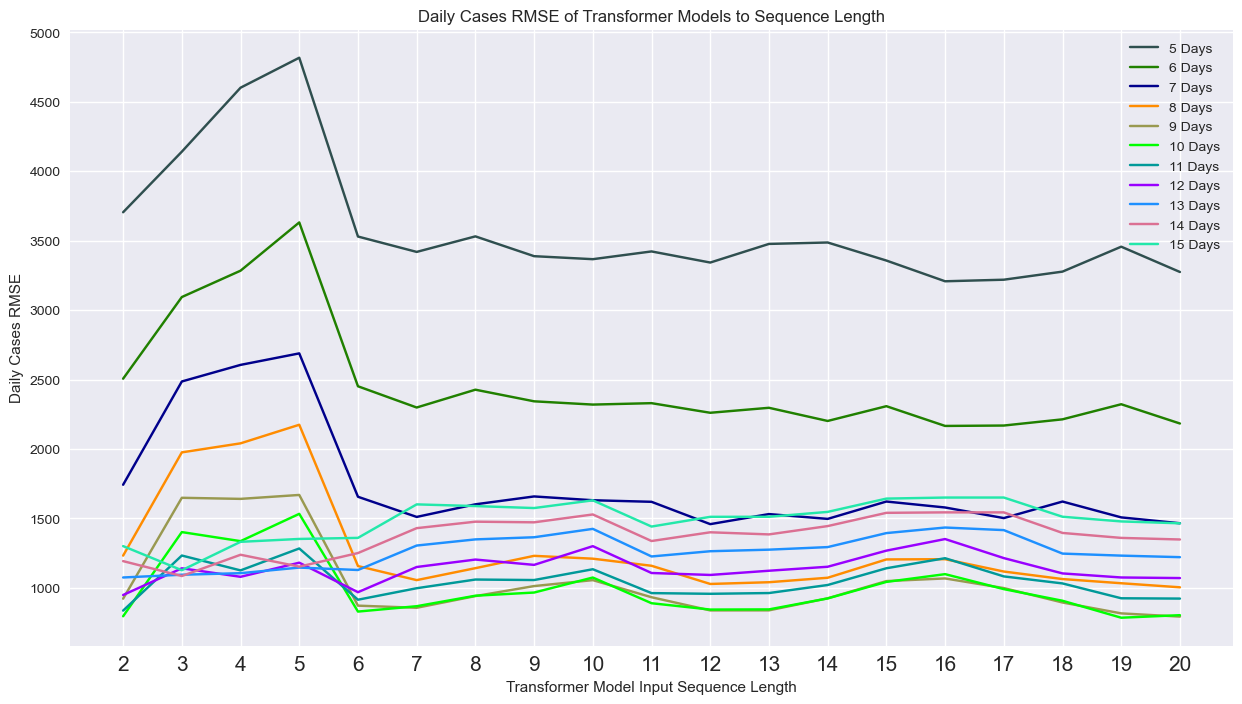

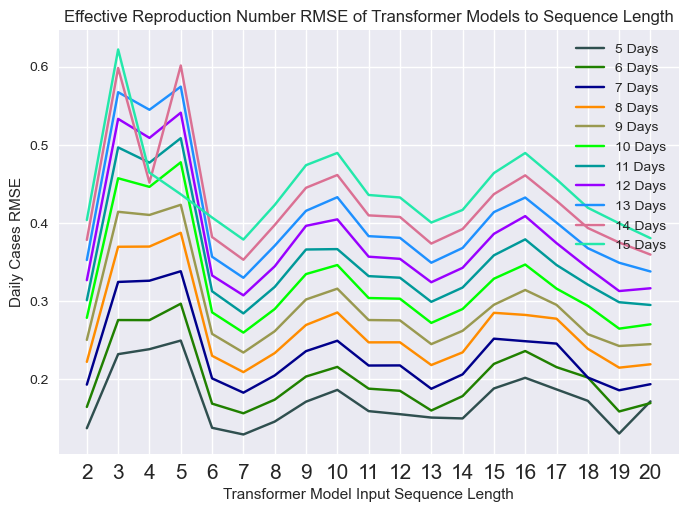

In [9]:
colors = {
    5 : '#2f4f4f',
    6 : '#208000',
    7 : '#00008b',
    8 : '#ff8c00',
    9 : '#999950',
    10 : '#00ff00',
    11 : '#009999',
    12 : '#9900ff',
    13 : '#1e90ff',
    14 : '#db7093',
    15 : '#23e8aa' 
}

plt.style.use('seaborn')

plt.figure(figsize=(15,8))

for j in errors.keys():
    plt.plot(errors[j].loc[2:,'case_error'],color=colors[j])
plt.xticks(range(2,21),size=15)
plt.title('Daily Cases RMSE of Transformer Models to Sequence Length')
plt.ylabel('Daily Cases RMSE')
plt.xlabel('Transformer Model Input Sequence Length')
plt.legend([f'{d} Days' for d in errors.keys()])
plt.show()

for j in errors.keys():
    plt.plot(errors[j].loc[2:,'r_error'],color=colors[j])
plt.xticks(range(2,21),size=15)
plt.title('Effective Reproduction Number RMSE of Transformer Models to Sequence Length')
plt.ylabel('Daily Cases RMSE')
plt.xlabel('Transformer Model Input Sequence Length')
plt.legend([f'{d} Days' for d in errors.keys()])
plt.show()

In [13]:
@iw.interact(j = (5,15,1))
def plot_case_errors(j):
    plt.plot(errors[j].loc[2:,'sequence_length'],errors[j].loc[2:,'case_error'])
    plt.xticks(range(2,21))
    
    plt.title(f'Day {j} Cases RMSE')
    plt.xlabel('Day to Recovery')
    plt.ylabel('Error')
    plt.show()

interactive(children=(IntSlider(value=10, description='j', max=15, min=5), Output()), _dom_classes=('widget-in…

In [14]:
lowest = []
items = 0

for day in range(5,16):
    for input_length in errors[day]['sequence_length']:
        if input_length == 1:
            continue
        case_error = errors[day].loc[errors[day]['sequence_length'] == input_length,'case_error'].item()
        
        if case_error > 1000 or np.isnan(case_error):
            continue
        
        temp = [day,input_length,case_error]
        lowest.append(temp)
        
lowest = sorted(lowest, key=lambda x: x[2])

lowest

[[10, 19.0, 784.9041063998721],
 [9, 20.0, 792.9505485043802],
 [10, 2.0, 795.443697651017],
 [10, 20.0, 803.2414026855065],
 [9, 19.0, 816.1795253890583],
 [10, 6.0, 829.1234189383176],
 [11, 2.0, 836.0959031240516],
 [9, 12.0, 837.5170081436256],
 [9, 13.0, 837.8286616608293],
 [10, 12.0, 843.6566023455854],
 [10, 13.0, 844.8629225625533],
 [9, 7.0, 856.4547982666859],
 [10, 7.0, 867.870278757188],
 [9, 6.0, 871.8559362379425],
 [10, 11.0, 889.3025050297201],
 [9, 18.0, 894.5507246699689],
 [10, 18.0, 907.1048414021242],
 [11, 6.0, 914.5521737339031],
 [9, 2.0, 921.8906178782372],
 [11, 20.0, 922.704906762004],
 [10, 14.0, 923.8183306833192],
 [9, 14.0, 924.7563710924696],
 [11, 19.0, 924.92755813264],
 [9, 11.0, 932.4511630630436],
 [9, 8.0, 940.599667023762],
 [10, 8.0, 943.3714638915249],
 [12, 2.0, 948.4886310828962],
 [11, 12.0, 957.1648975369512],
 [11, 11.0, 962.1149256045431],
 [11, 13.0, 962.5504378008364],
 [10, 9.0, 966.2322189944624],
 [12, 6.0, 968.7422432076372],
 [10, 